In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import hydrant.mizuRoute.mizuRoute as mz
import subprocess
import os
from   shapely.geometry import Point

In [2]:
# inputs
path_out = './output/'
pfafs = ['71','78'] # 71 Saskatchewan, 78 Colombia
riv_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cat_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cst_path = '/project/rpp-kshook/Model_Output/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cst_file_template = 'hillslope_*_clean.shp'

In [3]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [4]:
riv, cat = gm.merit_read_file (pfafs,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template,
                               path_cst = cst_path,
                               cst_file_template = cst_file_template)

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


# prepare the network topology

In [5]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                            cat=cat,\
                            cat_cols={'id':'COMID', 'hillslope':'hillslope', 'area' :'unitarea'},\
                            network = 'merit')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:314: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:315: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


# Example-1 From Fraser River

In [6]:
# set the case name
prefix = 'Fraser_merit_'

In [7]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       outlet_id=[78011886]) # segment that is aimed to make the subbasin for

<Axes: >

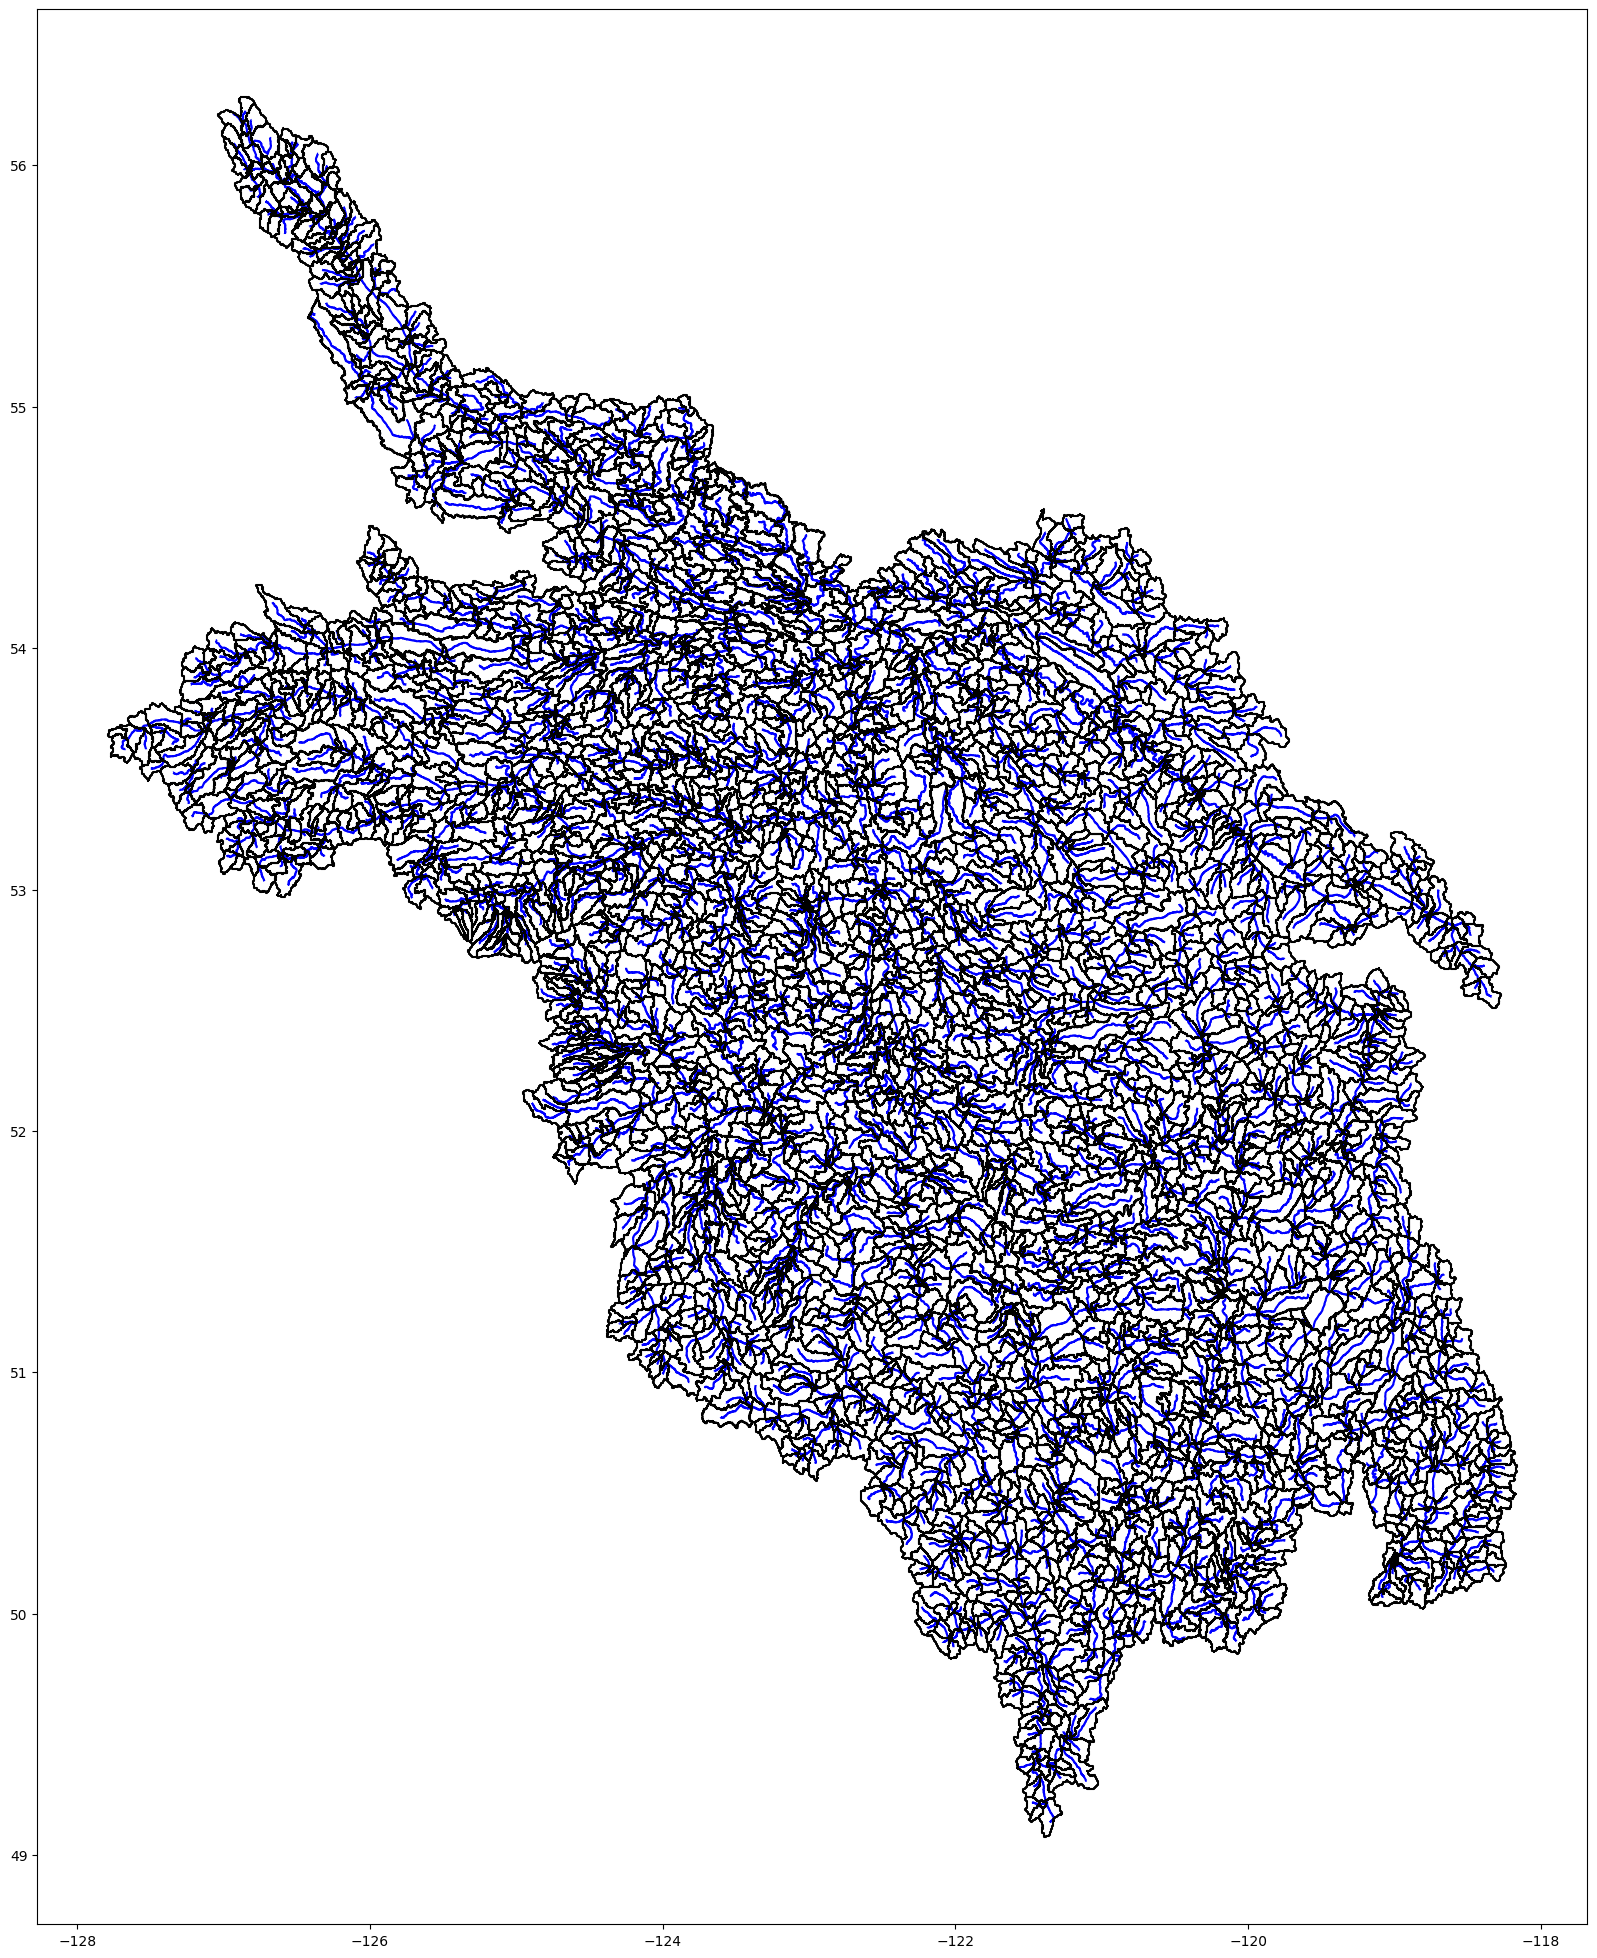

In [8]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [9]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 4554)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 ... 4547 4548 4549 4550 4551 4552 4553
Data variables: (12/20)
    COMID       (n) int64 78002433 78002480 78002505 ... 78013669 78013678
    length      (n) float64 5.663e+03 6.129e+03 ... 5.207e+03 3.541e+03
    lengthdir   (n) float64 4.947 5.742 2.976 0.7234 ... 7.736 2.127 4.689 3.257
    sinuosity   (n) float64 1.145 1.067 1.144 1.159 ... 1.203 1.309 1.11 1.087
    slope       (n) float64 7.05e-05 4.886e-05 0.02494 ... 0.1353 0.002542
    uparea      (n) float64 2.156e+08 1.212e+08 9.25e+07 ... 3.48e+07 3.96e+07
    ...          ...
    up4         (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    unitarea    (n) float64 26.99 16.67 11.85 26.73 ... 48.06 37.83 34.8 39.6
    latitude    (n) float64 56.1 56.15 56.07 56.07 ... 49.99 50.0 50.01 50.0
    longitude   (n) float64 -126.8 -126.8 -126.6 -126.6 ... -120.6 -121.9 -120.1
    width       (n) float64 15.68 12.01 10.62 6.17 ... 7.933 7.151 6.899 7.293

## save

In [10]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')


# Example-2 From basins of identified pfafs that intersect with Alberta and Saskatchewan

In [11]:
# set the case name
prefix = 'ALSASK_merit_'

In [12]:
# load the info and the provience
trg_shp = gpd.read_file('./data/province/provinces.shp')
sel_pr = ['Alberta','Saskatchewan']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)

In [13]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       shapefile=trg_provinces)

<Axes: >

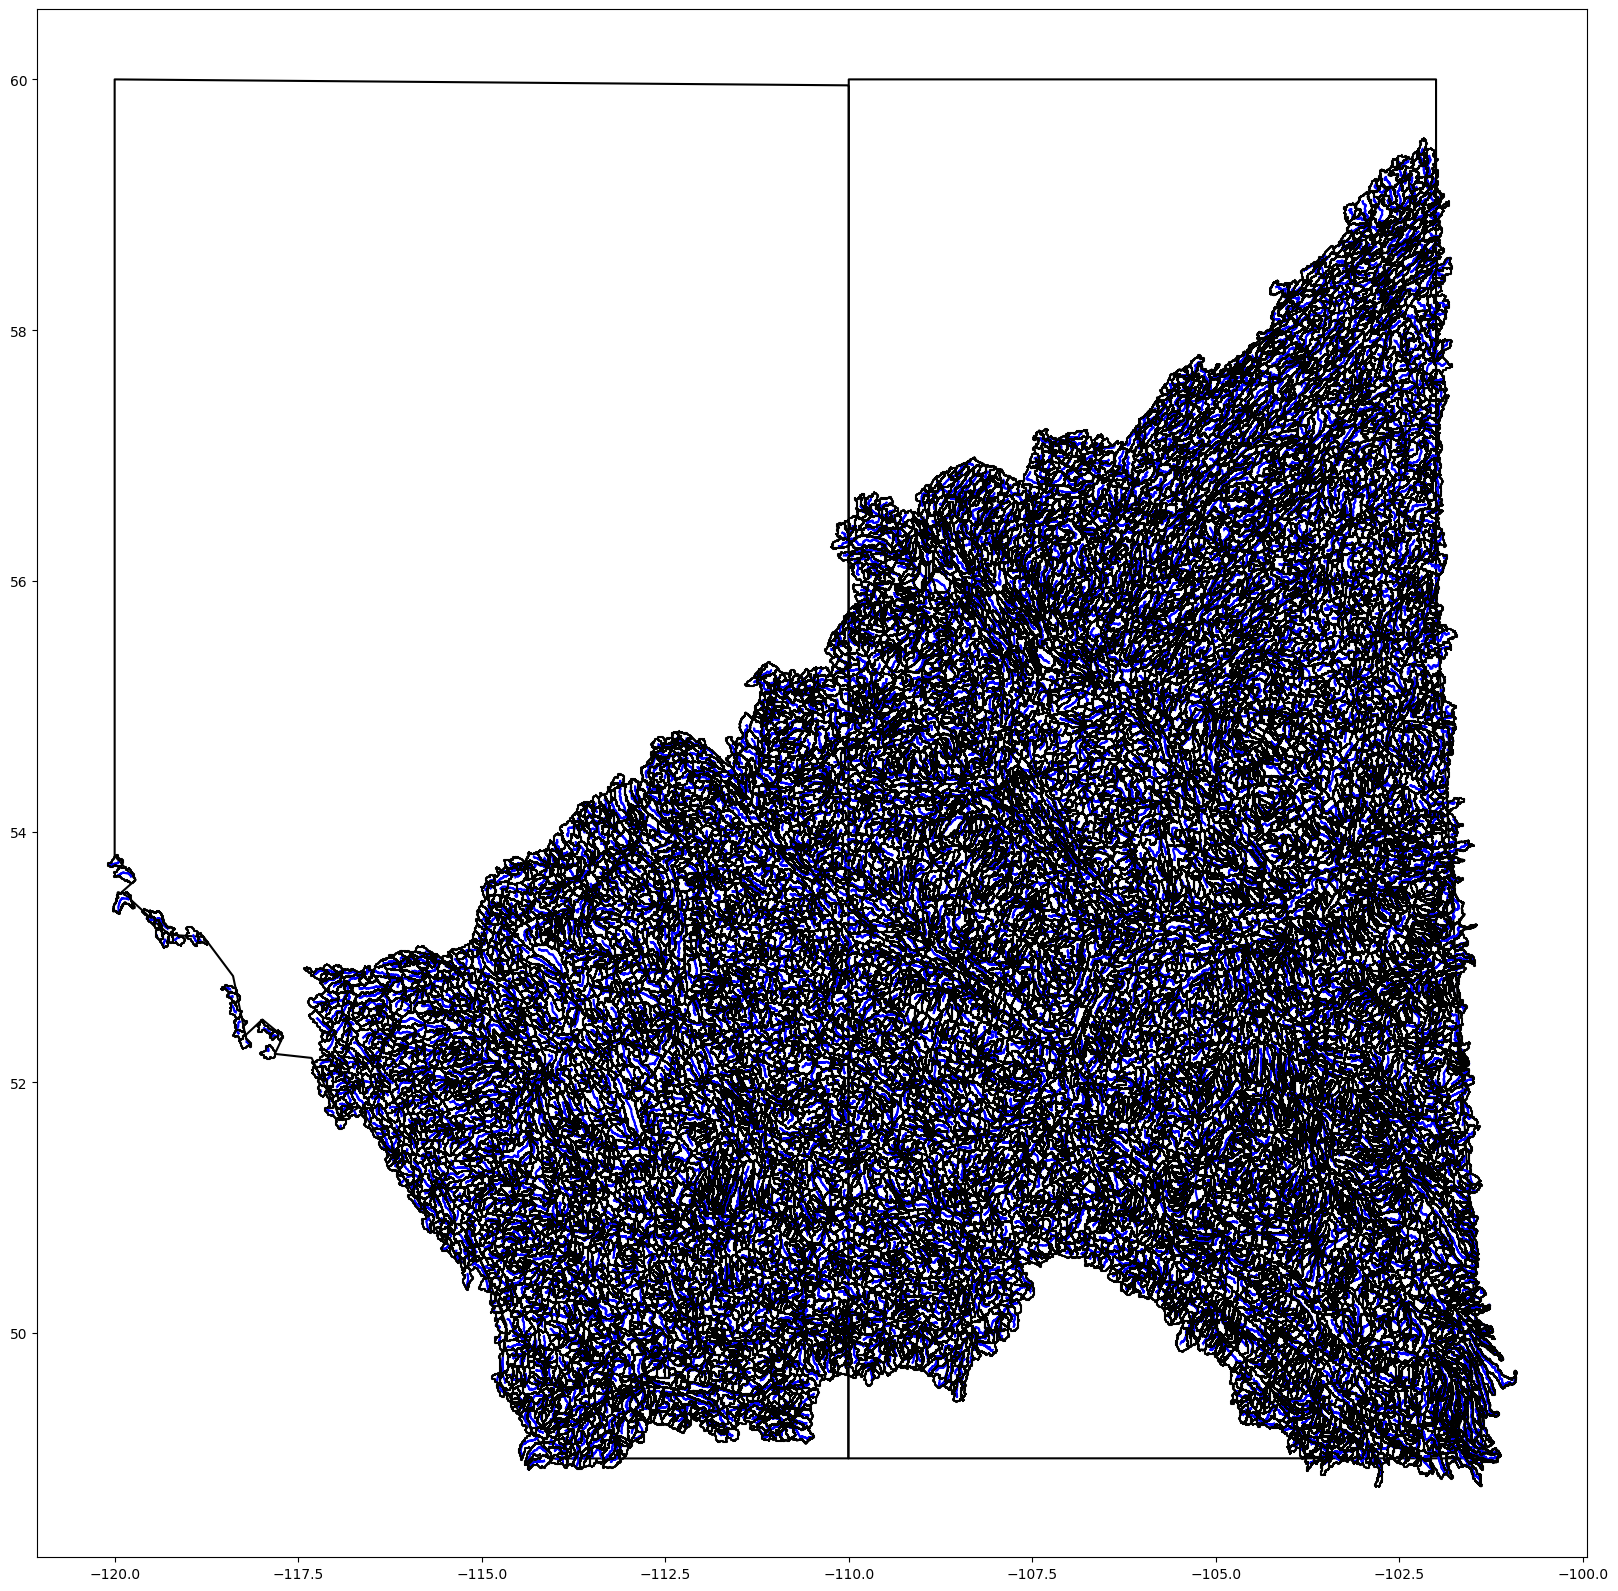

In [14]:
fig, ax = plt.subplots(figsize=(20,30))
trg_provinces.boundary.plot(ax=ax, color='k')
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')

In [15]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 16117)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 ... 16111 16112 16113 16114 16115 16116
Data variables: (12/20)
    COMID       (n) int64 71000025 71000026 71000027 ... 78014078 78015441
    length      (n) float64 1.72e+04 3.977e+03 1.241e+04 ... 3.672e+04 2.406e+04
    lengthdir   (n) float64 12.68 2.61 8.471 12.41 ... 6.832 25.68 24.16 18.86
    sinuosity   (n) float64 1.356 1.524 1.465 1.372 ... 1.153 1.599 1.52 1.276
    slope       (n) float64 0.0003943 0.0007272 0.0005707 ... 0.01166 0.01014
    uparea      (n) float64 1.959e+10 2.232e+09 ... 2.057e+08 1.465e+08
    ...          ...
    up4         (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    unitarea    (n) float64 53.97 28.63 63.28 46.27 ... 69.44 218.7 205.7 146.5
    latitude    (n) float64 58.96 59.02 59.04 59.05 ... 49.96 49.12 49.05 48.97
    longitude   (n) float64 -102.1 -102.0 -102.1 -102.2 ... -114.3 -114.2 -114.2
    width       (n) float64 141.0 48.25 47.52 39.58 ... 9.333 15.79 15.34 13.11

In [16]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')

# Example-3 From basins of identified pfafs that intersect with target stations in Alberta

In [17]:
# set the case name
prefix = 'stations_merit_'

In [18]:
data = {
    'Station ID': ['05BE004', '05BH004', '05BL004', '05CC002'],
    'seg ID': [71028039, 71027942, 71034975, 71022153],
    'Station name': [
        'BOW RIVER NEAR SEEBE',
        'BOW RIVER AT CALGARY',
        'HIGHWOOD RIVER BELOW LITTLE BOW CANAL',
        'RED DEER RIVER AT RED DEER'
    ],
    'up': [0, 0, 0, 0],
    'X': [-115.03,-114.05,-113.86,-113.82],
    'Y': [51.11,    51.05,  50.58,  52.27]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [19]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



<Axes: >

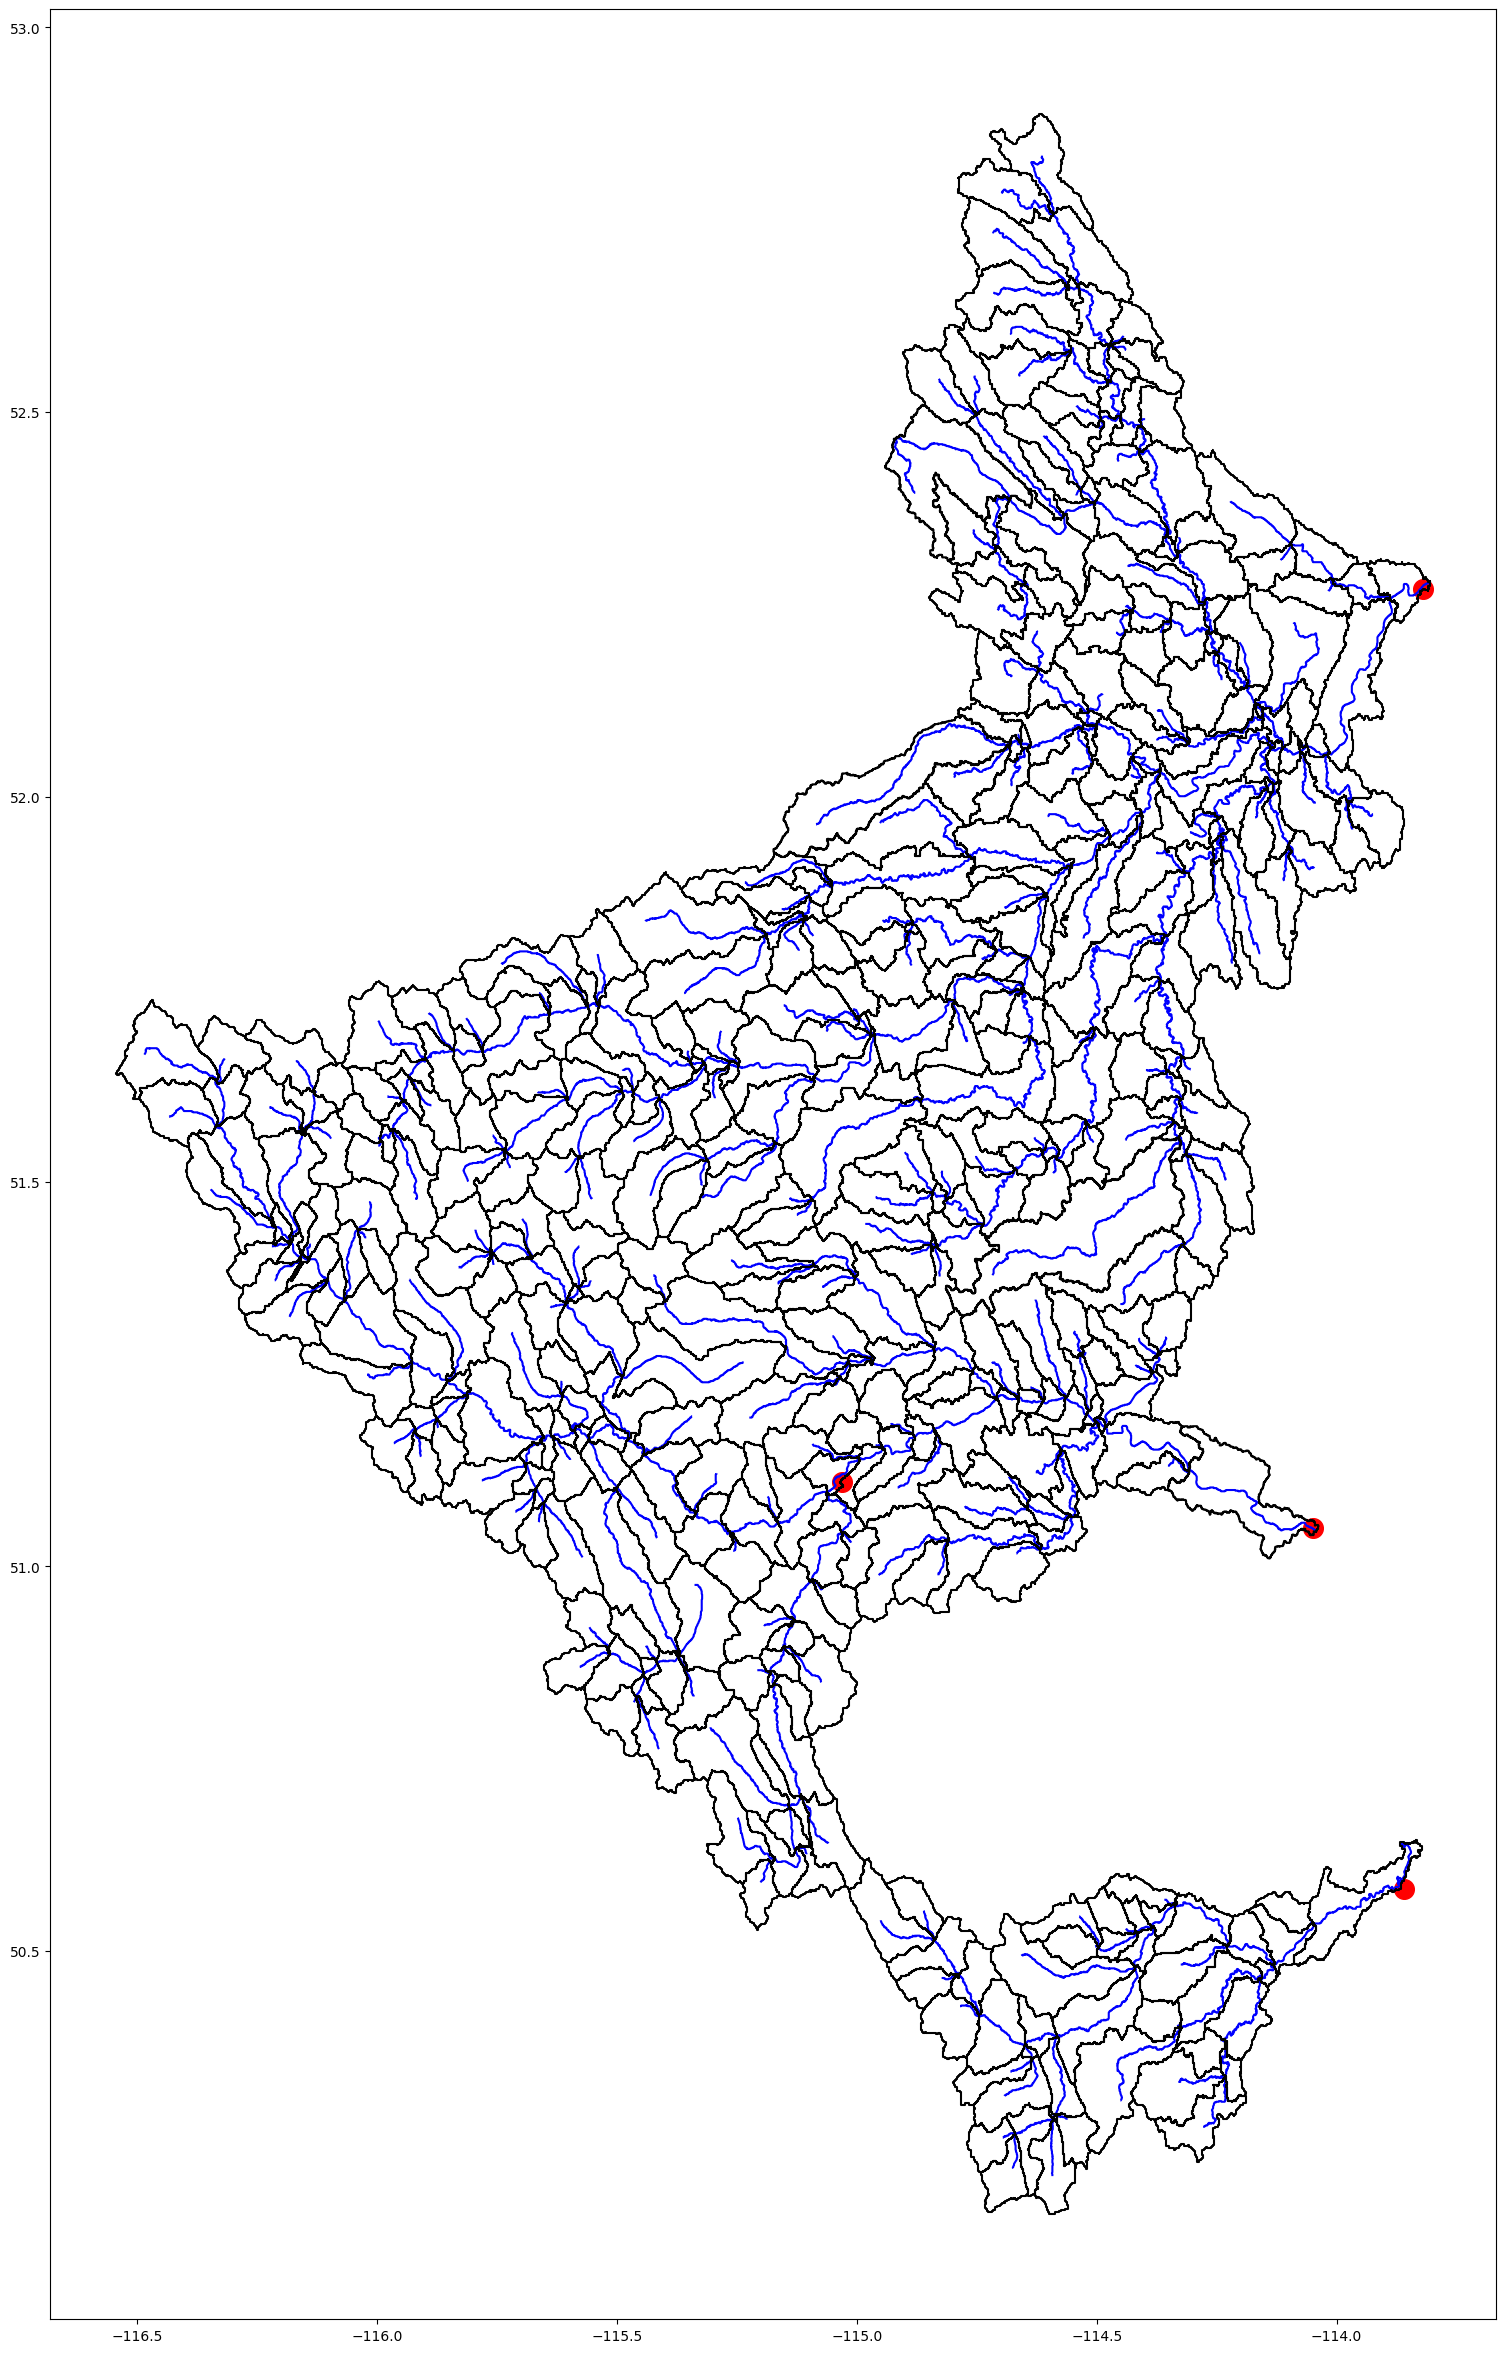

In [20]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [21]:
mz_ntopo = mz.create_nc_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
mz_ntopo

<xarray.Dataset>
Dimensions:     (n: 453)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 ... 445 446 447 448 449 450 451 452
Data variables: (12/20)
    COMID       (n) int64 71022153 71022160 71022164 ... 71039250 71039266
    length      (n) float64 9.651e+03 3.002e+04 ... 2.518e+03 1.198e+04
    lengthdir   (n) float64 6.073 23.71 3.242 1.22 ... 4.938 4.428 2.041 10.24
    sinuosity   (n) float64 1.589 1.266 1.27 1.134 ... 1.277 1.25 1.234 1.17
    slope       (n) float64 0.0009722 0.0008482 0.0009692 ... 0.03278 0.005844
    uparea      (n) float64 1.172e+10 1.142e+10 ... 2.796e+07 1.137e+08
    ...          ...
    up4         (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    unitarea    (n) float64 41.33 135.8 11.0 1.473 ... 41.99 52.09 27.96 113.7
    latitude    (n) float64 52.28 52.15 52.07 52.06 ... 50.93 50.92 50.95 50.94
    longitude   (n) float64 -113.9 -114.0 -114.0 -114.1 ... -115.2 -115.0 -115.3
    width       (n) float64 109.3 107.9 106.6 106.5 ... 7.48 8.218 6.288 11.66

In [22]:
cat_slice.to_file(path_out+prefix+'cat.shp')
riv_slice.to_file(path_out+prefix+'riv.shp')
mz_ntopo.to_netcdf(path_out+prefix+'mizuRoute_ntopo.nc')